# Part 1: Analisis de dades

In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

        
train = pd.read_csv(r'/Users/Usuario/Desktop/UNI 4/APC/Cas Kaggle/Cas_Kaggle_Mallol_Bernat/data/train_gr/train.csv')
testpd = pd.read_csv(r'/Users/Usuario/Desktop/UNI 4/APC/Cas Kaggle/Cas_Kaggle_Mallol_Bernat/data/test_gr/test.csv')
train.head()
Y_train = train['user_suggestion']
X_train = train['user_review']
Y_train.shape


(17494,)

Com podem observar, un cop carregades les dades, he volgut mostrar els 5 primers documents del training set.
Cal destacar que aquest, compta amb 5 variables diferents, les quals considero que hi han 2 que son molt importants.

Per una part, tenim la variable independent de TIPUS TEXT -> user_review
Per altre banda, tenim la variable que voldrem predir, o variable dependent/target -> user_suggestion

Podem observar també, 2 coses més, la primera i crec més important, es que la variable sobre la que treballaré, per poder predir el target, no es ni numerica, ni categorica, sino de tipus text, i per això, ja puc descartar directament utilitzar regressió logistica, ja que aquesta no treballa amb variables de tipus text, sino amb variables numeriques o categoriques (de mes de 2 categories).

L'altre cosa a observar, es que el target es una variable numerica binaria, es dir només pot prendre per valor 1 o 0, i aquesta variable basicament indica si l'usuari recomanaria el joc o no.

El que hauré de fer doncs, es a partir de el comentari que hagi deixat, predir si l'usuari recomenaria o no el joc, per això abans, haurem de processar les dades, i molt probablement haure de generar un diccionari X[i,j] on X serà la paraula, i serà l'index d'un determinat document, i finalment, j serà el nombre de cops que apareix la paraula X en el document i

En quant les altres variables (review_id, title, year), considero que son merament informatives, per lo tant, no les utilitzaré per entrenar al meu model.

Una altre visualització que podriem fer, es veure el nombre de paraules que té cada user_review.

In [2]:
df = train.copy()
df["n_words"] = df["user_review"].apply(lambda s: len(s.split()))
dataClean  = df[["title","user_review", "user_suggestion", "n_words"]]
dataClean.head()



,title,user_review,user_suggestion,n_words
0,Spooky's Jump Scare Mansion,I'm scared and hearing creepy voices. So I'll...,1,132
1,Spooky's Jump Scare Mansion,"Best game, more better than Sam Pepper's YouTu...",1,44
2,Spooky's Jump Scare Mansion,"A littly iffy on the controls, but once you kn...",1,70
3,Spooky's Jump Scare Mansion,"Great game, fun and colorful and all that.A si...",1,47
4,Spooky's Jump Scare Mansion,Not many games have the cute tag right next to...,1,67


Com podem observar, he transformat el dataset, natejant algunes variables com l'identificador o l'any de la review, i he afegit per cada document, el nombre de paraules que conté cada review, per tenir una idea general del tamany del comentari.

Amb això, he pogut observar també, que hi ha una tendencia a que l'usuari recomani el joc si el comentari es mitjanament curt, i 
que no el recomani si el comentari es llarg, per verificar això, he volgut fer una correlació tenint en compte
els tamanys dels comentaris, considerant un comentari extens si aquest compta amb més de 300 paraules, i considerant-lo curt si conté menys de 300 paraules.

In [3]:
# for i in dataClean:
#     if i['user_suggestion']== 0:
#         print(i)
        
print(dataClean[['title','user_suggestion','n_words']][dataClean.user_suggestion==0])

                             title  user_suggestion  n_words
8      Spooky's Jump Scare Mansion                0      966
91     Spooky's Jump Scare Mansion                0       65
93     Spooky's Jump Scare Mansion                0       80
99     Spooky's Jump Scare Mansion                0       51
100    Spooky's Jump Scare Mansion                0       40
...                            ...              ...      ...
17421            School of Dragons                0      325
17422            School of Dragons                0       54
17423            School of Dragons                0      332
17425                 EverQuest II                0      158
17488                 EverQuest II                0       39

[7526 rows x 3 columns]


Aparentment, sembla que l'observació que he fet, sigui erronea, ja que amb els 10 valors estem visualitzant, només 1 cumpleix la condició que habia dit, no gens menys, com que només estem visualitzant els 5 primers i 5 ultims documents, faré un gràfic per mostrar-ho d'una manera més visual.

Nombre de comentaris positius: 9968
Nombre de comentaris negatius: 7526


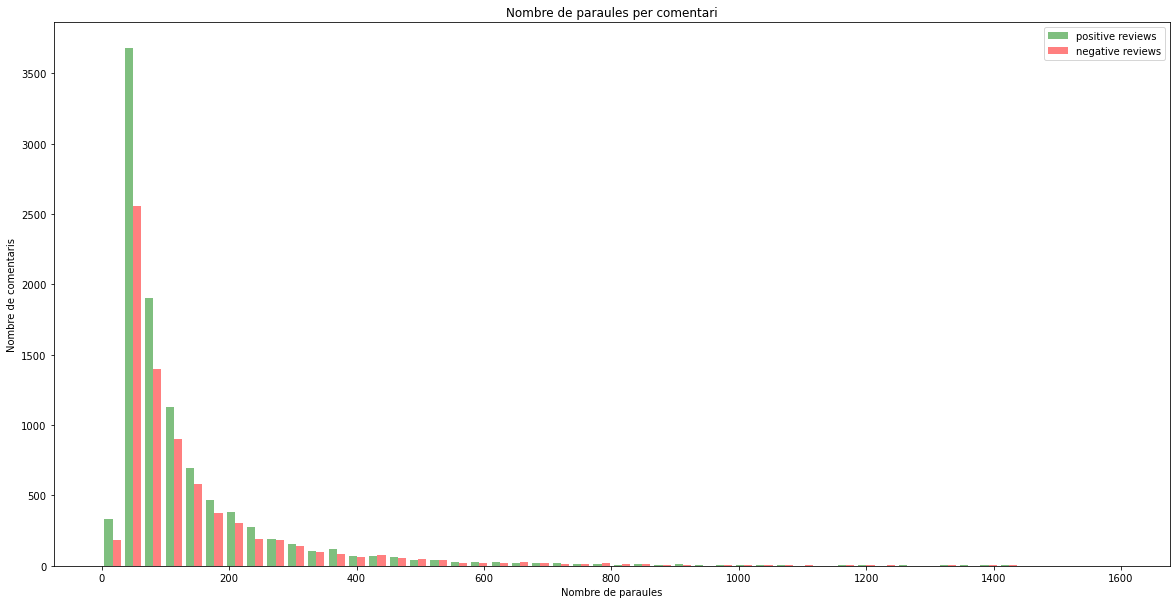

In [4]:
positiveUserSugg = dataClean[dataClean['user_suggestion']==1]['n_words']
negativeUserSugg = dataClean[dataClean['user_suggestion']==0]['n_words']

print("Nombre de comentaris positius: " + str(len(positiveUserSugg)))
print("Nombre de comentaris negatius: " + str(len(negativeUserSugg)))

plt.figure(figsize=(20,10))
plt.hist([positiveUserSugg, negativeUserSugg], bins=50, alpha=0.5, label=['positive reviews', 'negative reviews'],color=['g','r'])
plt.title("Nombre de paraules per comentari")
plt.xlabel("Nombre de paraules")
plt.ylabel("Nombre de comentaris")
plt.legend()
plt.show()

La primera conclusió que podem treure d'aquest gràfic, es que la majoria dels comentaris, tenen entre 0 i 200 paraules, i d'aqui extreiem la gran diferencia de reviews positives i negatives, siguent en aquest rang (entre 0 i 200 paraules), molt més comú que el comentari sigui positiu, que negatiu.

L'altre cosa que podem veure, es que a partir de les 400 paraules, ja podem trobar casos en que hi hauran mes comentaris negatius que positius.

Per concluir, no podem dir que hi hagi una bona correlació treballant amb el nombre de paraules dels comentaris, es per això que no utilitzarem aquesta variable, si la tendencia seguís com en el cas del rang (0 a 200 paraules), fins al final (1600 paraules o mes), si que podriem utilitzar n_words.

Per asegurarnos però, mirarem la correlació que hi ha entre target i la variable n_words:

In [5]:
dataClean.corr()

,user_suggestion,n_words
user_suggestion,1.000000,-0.043512
n_words,-0.043512,1.000000


No ens fa falta realitzar un mapa de calor per veure la poca correlació que hi ha entre n_words i user_suggestion.

# Part 2: Preprocessing

En aquesta segona part, basicament preparare el meu dataset per a poder treballar amb ell comodament, això inclou eliminar comentaris sense sentit, o dit d'una altre forma, comentaris en els quals hi apareixen caracters especials, i careixen de cap mena d'informació rellevant util per l'entrenament dels nostres models.

Aquesta segona part, la dividiré en 2 seccions, la primera secció, es on natejaré el meu conjunt d'entrenament, tenint en compte 2 coses:

    1a) Voldré borrar comentaris sense sentit, o dit d'una altre forma, comentaris en els quals hi apareixen caracters                   especials, i careixen de cap mena d'informació rellevant util per l'entrenament dels nostres models.
    
    2a) Com que haure de treballar amb les paraules de les reviews, posant-lis pes i frequencia d'aparició, m'interesa borrar també parts de comentaris les quals sempre es repeteixen, que vull dir amb aixó?
    
        Només donant una ullada al conjunt d'entrenament, he pogut observar que hi ha moltes reviews que començen amb 2 posibles frases diferents que son : 'Product received for free' i 'Early Access Review', com que aquestes frases es repeteixen en molts comentaris d'usuaris diferents, he arribat a la conclusió que aquestes, no han estat redactades per els usuaris, sino que s'han generat automaticament (podria ser donat a la selecció d'alguna opció), això significa que si no estan redactades per el mateix usuari, no les hauria de tenir en compte a l'hora de entrenar el meu model, i es per això que eliminare aquestes 2 frases de tots els reviews posibles.


En la segona secció, basicament creare un diccionari on per cada paraula, mostrare la seva frequencia (cops que apareix) i li donare un pes.

1a Secció - Part 1: Miraré si el comentari conté algun caracter que no sigui ASCII, en cas que contingui un 10% de caracters no ASCII, descartaré el comentari en questió.

In [6]:
dataClean  = df[["title","user_review", "user_suggestion"]].values.tolist()
comentarisNets = []

def isClean(doc):
    charsTotals=len(doc)
    charsNets=0
    for char in list(doc):
        if(ord(char) > 0 and ord(char) < 128):
            charsNets = charsNets + 1
    return (charsNets / charsTotals) >= 0.9
    


for comentari in dataClean:
    if isClean(comentari[1]):
        comentarisNets.append(comentari)

print("Han quedat els seguents comentaris nets: {0}".format(len(comentarisNets)) + " de " + str(len(dataClean)) + " comentaris existents" )




Han quedat els seguents comentaris nets: 17326 de 17494 comentaris existents


1a Secció - Part 2: Com he comentat abans, en aquesta part 2 de la secció 1, em dedicare a borrar principis de comentaris que no hagin estat escrits per el mateix usuari, es dir que s'hagin generat d'una altre forma.

Cal tenir en compte, que en el cas que hi hagin molts inicis de comentari com els que acabem de comentar, el fet de borrarlos, farà que poguem treballar molt millor amb el train dataset i alhora, el diccionari que generem, no serà tan gran.

In [7]:
def eliminarIniciGeneratAutomaticament(doc, automaticInsertions, counter):
    for iniciAutomatic in InicisGeneratsAutomaticament:
        if doc.startswith(iniciAutomatic):
            counter+=1
            return (True, doc[len(iniciAutomatic):], counter)
    return (False, doc, counter)

InicisGeneratsAutomaticament = ["Early Access Review", "Product received for free"]

originals = []
counter=0
for comentari in comentarisNets:
    correcio, comentariCorretgit, counter = eliminarIniciGeneratAutomaticament(comentari[1], InicisGeneratsAutomaticament,counter);
    
    if correcio == False:
        originals.append(comentari[1])
        comentari[1] = comentariCorretgit
        
print("Han estat eliminats: "+str(counter)+" inicis automatics")



Han estat eliminats: 5997 inicis automatics


In [8]:
print(originals[1])

Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A computerSome extra pants.Pros:Scary as hell.Fun.Adventure.Spooky.Did I forgot to mention that its scary as hell?You'll get more pants/briefs in your wardrobe.Time consuming if you're bored.Cons:Buying pants/briefs. You haven't downloaded it yet.


Un cop net el dataset, jo podem procedir a transformar-lo en un diccionari, el qual per cada paraula, li donarem una frequencia, per finalment donarli un pes, cal tenir en compte però, que la frequencia de cada paraula serà a nivell de dataset, i no de document, ja que així ens aseguirem un equilibri a l'hora d'assignar frequencies, si ho fesim per document, quedaria molt desaquilibrat al haver-hi desde comentaris que contenen fins a 5k paraules fins 10 paraules.

Per generar el diccionari, utilitzare la llibreria nltk (natural language toolkit), la cual ens permet, entre moltes coses, processar variables de text, que es el que ara necesitem.


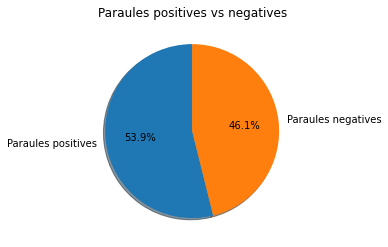

["Spooky's Jump Scare Mansion", "Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A computerSome extra pants.Pros:Scary as hell.Fun.Adventure.Spooky.Did I forgot to mention that its scary as hell?You'll get more pants/briefs in your wardrobe.Time consuming if you're bored.Cons:Buying pants/briefs. You haven't downloaded it yet.", 1]


In [9]:
import string 
import nltk
from collections import defaultdict
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

sbStemmer = SnowballStemmer("english")
diccionariAntic = {}
def memoritzador(paraula): 
    if paraula in diccionariAntic:
        return diccionariAntic[paraula]
    else:
        stemmed = sbStemmer.stem(paraula)
        diccionariAntic[paraula] = stemmed
        return stemmed
    
punctuationRemover = str.maketrans(string.punctuation, ' '*len(string.punctuation))

def contadorParaules(lines):
    wordCountDict = defaultdict(int)
    for line in lines:
        for paraula in line.lower().translate(punctuationRemover).split():
            wordCountDict[memoritzador(paraula)] += 1
    return wordCountDict

def obtenirFrequencia(lines):
    frequenciaDocument = defaultdict(int)
    for line in lines:
        wordSet = set(line.lower().translate(punctuationRemover).split())
        for paraula in wordSet:
            frequenciaDocument[memoritzador(paraula)] += 1
    return frequenciaDocument

comentarisPositius = [t[1] for t in comentarisNets if t[2] == 1]
comentarisNegatius = [t[1] for t in comentarisNets if t[2] == 0]
nombreParaulesPositives = contadorParaules(comentarisPositius)
nombreParaulesNegatives = contadorParaules(comentarisNegatius)               
frequenciaPositius = obtenirFrequencia(comentarisPositius)
frequenciaNegatius = obtenirFrequencia(comentarisNegatius)

for stopword in stopwords.words('english'):
    nombreParaulesPositives.pop(stopword, None)
    nombreParaulesNegatives.pop(stopword, None)

negativeCols = [(paraula, count, frequenciaNegatius[paraula]) for paraula, count in nombreParaulesNegatives.items()]
positiveCols = [(paraula, count, frequenciaPositius[paraula]) for paraula, count in nombreParaulesPositives.items()]

plt.pie([len(nombreParaulesPositives),len(nombreParaulesNegatives)], labels=['Paraules positives','Paraules negatives'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Paraules positives vs negatives')
plt.show()

print(comentarisNets[1])

Un cop fet el prepprocessament de dades, ja podem pasar a la seguent part, on farem la comparativa entrenant 2 models i comentarem els resultats.

# Part 3.1: Naive Bayes

En aquest sub apartat, entrenarem amb el model Naive Bayes, ja que es un dels pocs que ens permet treballar amb variables de text.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
ntlkStopWords = list(stopwords.words('english'))
import timeit
vectorizer = CountVectorizer(stop_words=ntlkStopWords, max_features=10000)

data_user_review = [comentari[1] for comentari in comentarisNets]
data_user_suggestion = [comentari[2] for comentari in comentarisNets] 

data_vec = vectorizer.fit_transform(data_user_review);
train_X, test_X, train_Y, test_Y = train_test_split(data_vec, data_user_suggestion, test_size=0.2, random_state= 0xDEADBEEF)

mnb = MultinomialNB()
startTime=timeit.default_timer()
mnb.fit(train_X, train_Y)
endTime=timeit.default_timer()
t=endTime-startTime

print("Precisió Naive Bayes: {0} %".format(mnb.score(test_X, test_Y) * 100) + ", entrenament fet en: {0} segons".format(t))


Precisió Naive Bayes: 84.44893248701673 %, entrenament fet en: 0.006440500000000071 segons


Podem dir que amb el model Naive Bayes, hem obtingut una bona precisió, però també es important veure el temps que ha tardat en fer l'entrenament, aquest es molt baix, per la cual cosa, podem afirmar que aquest, es un bon model per al nostre cas.

# Part 3.2: SVC lineal

En aquest segon subapartat, utilitzare com a model linear SVC, ja que entre altres coses, ens permet treballar amb entrades (variables independents) "sparse", o dit d'una altre manera, ens permet treballar amb dicionaris clau-valor, om es el nostre cas, tenint en compte, que quan més gran sigui el diccionari, més probabilitat de tenir una precisió alta tindrà el nostre model.

In [11]:
from sklearn.svm import LinearSVC
import seaborn as sns

classSVC= LinearSVC(max_iter=1000, tol=1e-5, dual=False, C=0.01)
startTime=timeit.default_timer()
classSVC.fit(train_X, train_Y)
endTime=timeit.default_timer()
t=endTime-startTime
print("Precisió SVC lineal: {0} %".format(classSVC.score(test_X, test_Y) * 100) + ", entrenament fet en: {0} segons".format(t))


Precisió SVC lineal: 85.48759376803231 %, entrenament fet en: 12.836964300000002 segons


Com podem observar, aquest model, te millor precisió que el de Bayes, però per el que fa al temps d'entrenament, es molt, MOLT pitjor.

# Part 4: Estudi de resultats i conclusions

Per concluir aquest estudi, no ens queda cap altre cosa que comentar els resultats tant de precisio com de temps qe hem obtingut.

Per una part, tenim l'entrenament de Naive Bayes, al no haberlo vist abans, m'ha sigut una mica complicat treballar amb ell, però un cop acostumat, i vistos els resultats, he pogut veure que era un molt bon model, sobretot en casos en els que tinguem poques dades, com es el meu cas, el qual estic treballant, despres de tota la nateja de dades, amb aproximadament 17000 documents.

En definitiva, Naive Bayes, ha donat bons resultats tant de precisió (84,44%) com de temps (0,006s), que es el que ha tardat en fer l'entrenament del training set.

Per altra banda, tenim el SVC linear, aquest classificador, ja l'habiem vist a classe, per tant, no m'ha sigut tant complicat treballar amb ell com amb el cas anterior.
Abans de parlar dels resultats obtinguts, cal tenir en compte que quantas més mostres tinguem, millor precisió donarà aquest model. Saben això, els resultats obtinguts han estat una mica sorprenents, ja que en termes de precisió, ha estat inclus una mica millor que Naive Bayes, amb  una precisió d'aproximadament 85,54%, no gens menys, el temps ha estat "fatidic", ja que ha tardat 7,25 segons, bastantes ordres de magnitud més que el que ha tardat Naive Bayes en entrenar.

Així doncs, posant-me en la pell d'algú que estigues utilitzant aquests models en la seva carrera professional, si el que busco es explicitament, el maxim de precisió, sense importar el temps que tardi en entrenar el model, em quedaria amb el SVC  linear, si el que busco es una bona precisió i un bon temps, sens dubte, Naive Bayes es el que hauriem d'elegir.

No gens menys, posant tots els resultats obtinguts sobre la taula, considero que es bastant millor Naive Bayes, ja que en el nostre cas, treballem amb poques dades, i la diferencia abismal de temps ha fet que em decanti per aquest model, tot i tenir menys precisió que SVC lineal.

Per acabar, comentar que la feina complicada en aquest estudi, no ha estat treballar amb els models, sinó preparar les dades per a que siguin valides per a entrenar aquests models, ja que les dades amb les que anabem a treballar, eren comentaris, es dir variables de text, i el procés de pasar aquest comentari a un vector de caracteristiques per despres convertir-ho en un diccionari al qual li he donat pes i frequencia, ha estat la part més complicada sens dubte.